In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using BenchmarkTools
using Distributed
using IntervalArithmetic, IntervalRootFinding
include("/home/julian/Hamburg/LadderDGA/run.jl");

using 8 workers.
      From worker 7:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


      From worker 6:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 5:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 2:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 8:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 3:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 4:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


┌ Warning: ArgParse not working with jupyter notebooks
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:48
┌ Warning: Check U and Beta consistency in chi_dir/gamma_dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:49
┌ Info: Reading Inputs...
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:51
┌ Info: Reading Fortran Input, this can take several minutes.
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:95
┌ Info: Done Reading Gamma
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:109
┌ Info: Done Reading chi
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:111
┌ Info: loading from 
│   env.inputVars = vars.jld
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:62
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:72
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local 

[ Info: Done.


In [2]:
c_χupup(χch, χsp) = χch .+ χsp
usable_ω = intersect(nlQ_ch.usable_ω, nlQ_sp.usable_ω)
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
χch_in = nlQ_ch.χ #[usable_ω,:]
χsp_in = nlQ_sp.χ #[usable_ω,:]
size(χsp_in)

(81, 56)

In [27]:
using LsqFit
function χ_λq(χ, λq)
    mapslices(χi -> 1.0 ./ ((1.0 ./ χi) .+ λq), χ, dims=[2])
end

tail_func_real_tmp(iωn, c) = real.(c[1] ./(iωn .^ 2))

function cond3_tail(χupup; min_ω=3)
    nh = ceil(Int64, size(χupup,1)/2)
    iω_arr = LadderDGA.iω_array(mP.β, nh)[min_ω+1:end]
    
    p0 = [0.0]
    mapslices(ydata->curve_fit(tail_func_real_tmp, iω_arr, ydata, p0), χupup[nh+min_ω:end,:], dims=[1])[1,:]
end
Wν    = tc ? build_weights(1, sP.n_iν, [0,1,2,3,4]) : nothing
Wω    = tc ? build_weights(1, floor(Int64, length(usable_ω)/2), [0,1,2,3]) : nothing
Gνω = convert(SharedArray,Gfft_from_Σ(Σ_loc_pos, ϵkGrid, -sP.n_iω:(sP.n_iν+sP.n_iω-1), mP))
tmp = SharedArray{Complex{Float64},3}(length(usable_ω), size(bubble,2), sP.n_iν)
ϵqGrid = reduce_kGrid(cut_mirror(collect(ϵkGrid)));
Σ_hartree = mP.n * mP.U/2
Σ_ladder_ω = SharedArray{Complex{Float64},3}(length(usable_ω), length(1:sP.n_iν), length(qIndices)) 
χsp_λq = SharedArray{Complex{Float64},2}(size(χsp_in)...)
χch_λq = SharedArray{Complex{Float64},2}(size(χch_in)...)
E_kin_tail_c = [zeros(size(ϵqGrid)), (ϵqGrid .+ Σ_hartree .- mP.μ)]
tail = [1 ./ (LadderDGA.iν_array(mP.β, 0:(sP.n_iν-1)) .^ n) for n in 1:length(E_kin_tail_c)]
E_kin_tail = sum(E_kin_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* ϵqGrid , [1, -(mP.β) .* E_kin_tail_c[2]]))
norm = (mP.β * sP.Nk^mP.D)


function cond3(λq_sp, λq_ch)
    gridShape = repeat([sP.Nk], mP.D)
    transform = reduce_kGrid ∘ ifft_cut_mirror ∘ LadderDGA.ifft 
    transformK(x) = LadderDGA.fft(expand_kGrid(qIndices, x))
    transformG(x) = reshape(x, gridShape...)
    # --- Calculate new Sigma ---
    Σ_internal2!(tmp, usable_ω, bubble, view(FUpDo,:,(sP.n_iν+1):size(FUpDo,2),:), tc, Wν)
    χsp_λq[:,:] .= χ_λq(χsp_in, λq_sp)
    χch_λq[:,:] .= χ_λq(χch_in, λq_ch)
    Σ_internal!(Σ_ladder_ω, usable_ω, χsp_λq, χch_λq,
                view(nlQ_sp.γ,:,:,(sP.n_iν+1):size(nlQ_sp.γ,3)), view(nlQ_ch.γ,:,:,(sP.n_iν+1):size(nlQ_ch.γ,3)),
                Gνω, tmp, mP.U, transformG, transformK, transform)
    Σ_new = mP.U .* sum_freq(Σ_ladder_ω, [1], tc, mP.β, weights=Wω)[1,:,:] ./ (sP.Nk^mP.D)

    Σ_corr = Σ_new .- Σ_ladderLoc .+ Σ_loc_pos[eachindex(Σ_ladderLoc)]
    #println(all(Σ_corr .≈ Σ_ladder))
    G_corr = flatten_2D(G_from_Σ(Σ_corr .+ Σ_hartree, ϵqGrid, 0:sP.n_iν-1, mP));
    E_kin  = calc_E_kin(G_corr, Σ_corr, ϵqGrid, E_kin_tail, E_kin_tail_inv, qMult, norm)
    χupup_λq = real.(χch_λq .+ χsp_λq)[usable_ω,:]
    result = [coef(el)[1] - E_kin for el in cond3_tail(χupup_λq)]
    println(sum(abs.(result)))
    return result
    #return E_kin, E_pot
end

cond3 (generic function with 1 method)

In [28]:
testp = zeros(56)
cond3_test!(F, λ) = F[1:end] .= cond3(λ, zeros(56))
res = nlsolve(cond3_test!, testp)

13.836510625423076
13.836510494751447
13.836510756098711
13.83650980430306
13.836511446569379
13.83650889921218
13.83651235169168
13.83650941177661
13.83651183911126
13.83650968851443
13.83651156236635
13.836506640467162
13.836514610525782
13.836506375037796
13.836514875976729
13.836508260386626
13.836512990548968
13.83650550500322
13.836515746062744
13.836508490907153
13.836512760032722
13.836509492597404
13.836511758300341
13.836505722217108
13.83651552883429
13.836505309451592
13.836515941632543
13.836504532212418
13.83651671892519
13.836497144805177
13.836524106768469
13.836501552822149
13.836519698576469
13.836506427713575
13.836514823373415
13.836501008446502
13.836520243020276
13.83649606957202
13.836525182452078
13.836500673577941
13.836520578429035
13.836509267084548
13.83651198381265
13.836504644171047
13.836516606968173
13.836504030338308
13.83651722083924
13.83650284131041
13.836518409980533
13.836492978174151
13.83652827380205
13.836497732823373
13.836523519000693
13.83649

3.315638826798132
3.3156387170225976
3.315638809616611
3.3156387744799973
3.3156387521519415
3.315714635467767
3.315563016632253
3.31564404303067
3.315633480615476
3.315638673297305
3.3156388533821253
3.0617705770573997
3.0617705770573997
3.061770577095035
3.061770577019764
3.0617705801308537
3.0617705739839427
3.06177226461298
3.0617688893270714
3.061773019624253
3.061768134341027
3.061771870957393
3.0617692831133043
3.061770591823025
3.061770562294318
3.061770591680331
3.0617705624373643
3.061770196413962
3.061770957976242
3.0617705994553015
3.0617705546595757
3.0617706042444945
3.0617705498756718
3.0617706753488174
3.061770478764517
3.0617706013224772
3.061770552788423
3.061770600659365
3.061770553464174
3.061770724729134
3.0617704293969754
3.061770729728486
3.061770424386665
3.0617706460570324
3.0617705080564495
3.0617706038982933
3.0617705502283745
3.0617706458097564
3.0617705083038262
3.0617706209168634
3.06177053320261
3.0617705161719826
3.06177063795092
3.061770605436295
3.0617

2.6527715785770662
2.65277133881409
2.6527712420377267
2.652771338771677
2.6527712420658838
2.652770764834242
2.652771816040298
2.652769904151284
2.652772676793255
2.6527684106894105
2.6527741705980046
2.6527712092092965
2.6527713716276655
2.6527701158907298
2.652772465030984
2.6527661469521404
2.6527764346502103
2.652058214977427
2.6534862726415183
2.6527140807055085
2.652828468151509
2.65277117026382
2.652771410581126
2.6527711668906293
2.6527714139542975
2.652771012193316
2.652771568643841
2.6524552961800416
2.6530867511813576
2.6527504501355526
2.6527921425400747
2.6527710610876976
2.652771519757757
2.608093196395947
2.608093196395947
2.6080931963959486
2.608093196395945
2.6081058242568442
2.6080805651328
2.607919949203266
2.6082667452532595
2.6080968789455525
2.6080895135615005
2.608095440388853
2.60809095228678
2.6080932165362154
2.608093176255683
2.6080934634050057
2.6080929293845028
2.6080927071971995
2.6080936859282864
2.6080933300637796
2.608093062735864
2.6080932564494748
2.

2.4346453949876827
2.4346429534848246
2.43464674683729
2.4346075676361925
2.434682152955107
2.4345755510306004
2.434714084833071
2.4346450346454196
2.434644665485547
2.4346444343005516
2.434645265848422
2.4346446695167665
2.4346450305985634
2.43464475949733
2.434644940614538
2.4346446612297274
2.434645038891863
2.43464490647968
2.434644793640246
2.4346449032367237
2.4346447968761793
2.43464450101274
2.4346451991368703
2.434643953269102
2.434645746905277
2.434642995786259
2.4346467045820375
2.434644752037086
2.434644948083044
2.4346440889263463
2.4346456112334343
2.4346415397709653
2.4346481608356236
2.4341863425201047
2.4351045746028332
2.4346078576127503
2.434681821786047
2.434644716295455
2.4346449838248585
2.4346447075832947
2.4346449925292784
2.4346447782707443
2.43464492184961
2.434441194152288
2.4348481605386993
2.4346313940976825
2.4346583135879234
2.4346445890859276
2.434645111035182
2.4029524418145805
2.4029524418145805
2.4029524418145805
2.4029524418145805
2.4029699732358623


2.3390423968852456
2.339040970387659
2.3390417506859156
2.339041015866034
2.3390417052188077
2.3390396237595854
2.339043097403439
2.3390378148813378
2.3390449064908263
2.339036471598137
2.3390462501553033
2.339041264529611
2.339041456518659
2.3390405092575444
2.339042211844985
2.3390383526148497
2.339044368752859
2.338982482574723
2.3391002712554068
2.338922446293567
2.3391601598232343
2.33904160348213
2.3390411175778527
2.339040388205734
2.339042332947351
2.3390411379717784
2.339041583078026
2.3390411345093276
2.3390415865516023
2.3390410066629443
2.3390417144015627
2.339041415656478
2.3390413053989163
2.339041410331263
2.339041310724118
2.339040812626981
2.339041908460072
2.339039946835425
2.339042774332486
2.3390384439432945
2.3390442775260873
2.339041249230239
2.3390414718103867
2.3390401686065934
2.339042552536634
2.3390361032133584
2.3390466185998973
2.3383506135243954
2.3397339102661365
2.338978918509804
2.3391037662733822
2.3390412185306486
2.339041502532598
2.339041206136299
2

2.168217032112445
2.1682165627306325
2.1682170528752542
2.1682164792219836
2.1682171363778044
2.1682166731695314
2.168216942432351
2.168217294881022
2.1682163207207297
2.1682166849371862
2.1682169306525316
2.1681894907850587
2.1682441397995866
2.1682164537222284
2.1682171619034762
2.1682161023436604
2.168217513295023
2.1682165155743776
2.1682171000377948
2.16821660572567
2.1682170098775657
2.168215632552675
2.1682179831217434
2.1682144093918834
2.1682192064087844
2.1682135706225707
2.1682200454463305
2.1682167057843715
2.1682169098027404
2.1682162707752233
2.1682173448547317
2.16821483540962
2.1682187803868933
2.1681780385393066
2.1682555984706116
2.168118917783515
2.168314596397114
2.1682171571927142
2.168216458392236
2.1682159631186306
2.1682176525753407
2.1682166588440794
2.168216956741814
2.1682166544142016
2.1682169611949913
2.1682165897018106
2.1682170259156344
2.1682168666237813
2.168216748956097
2.1682168589463617
2.1682167566335906
2.16821646366041
2.168217151962906
2.16821589

2.116793701065643
2.116785469545203
2.1167954348366544
2.1167159509236213
2.1168651457306074
2.116755828521094
2.1168251883478453
2.1167908188382736
2.1167900747117017
2.11676872519239
2.1168122945319134
2.1167590557308795
2.116821947808095
2.116183050285615
2.1174016321181535
2.116790251506627
2.1167906420349953
2.1167892650671805
2.116791628542953
2.1167899934556758
2.1167909001259986
2.116790082147946
2.1167908114220926
2.1167900529964587
2.1167908405748497
2.116789968275356
2.1167909253044233
2.1167903061857785
2.1167905873750765
2.1167909881889098
2.116789905352582
2.116790255822388
2.1167906377293924
2.1167214257494025
2.116859518626921
2.1167898768078546
2.1167910167706347
2.1167893192041207
2.116791574403517
2.116790084087711
2.1167908094959427
2.116790125424506
2.1167907681422076
2.1167886245561833
2.1167922691259378
2.1167867050644564
2.1167941888259603
2.116785439759262
2.116795454517395
2.116790338993414
2.116790554552824
2.11678966389679
2.116791229688106
2.116787424530643

2.0752473998066643
2.0724380851004836
2.0724380851004836
2.0724380851004836
2.0724380851004836
2.0724692809003997
2.072406875955922
2.072300003240131
2.0725763854692993
2.0724456356563676
2.072430533676266
2.0724434365899933
2.0724327331418584
2.0724298283045557
2.072446369762849
2.0724315449901396
2.072444640582952
2.0723779635047204
2.072498382297779
2.0724085613479075
2.0724677083579355
2.07243850756708
2.0724376626168035
2.0724180884292127
2.0724581956844106
2.072411055771895
2.0724652040205753
2.0719355245608724
2.0730072563380677
2.0724379643888056
2.072438205808028
2.072437279420697
2.0724388908268363
2.07243778323995
2.072438386970056
2.0724378407723267
2.072438329432342
2.072437825506736
2.0724383447195085
2.0724377573036854
2.0724384128951234
2.072437942520242
2.072438227666712
2.072438679992445
2.0724374901967706
2.0724379675372706
2.072438202654714
2.0723841058211523
2.0724921079822805
2.072437702377828
2.072438467856375
2.072437325444314
2.0724388447916997
2.07243779176336

2.0387814367270995
2.037999528905543
2.039685823878991
2.0386236718713526
2.0389228997417828
2.0387731724910263
2.038773493441391
2.038773152590022
2.0387735133427545
2.03877312292376
2.038773543002318
2.0369960892579564
2.0411833215585973
2.0387489329409485
2.0387977444099388
2.0387730583657713
2.0387736075535505
2.027605168582137
2.027605168582137
2.027605168582137
2.027605168582137
2.02763867092934
2.027571651357235
2.027470887833488
2.027739659905589
2.0276132004654213
2.0275971357570532
2.027610915369442
2.027599421285273
2.027587666797262
2.027622729512646
2.027592450158886
2.0276179161620673
2.0274542940542295
2.027756703808904
2.0275555992804453
2.0276549000594954
2.027605634463736
2.0276047027032065
2.027569298349087
2.0276412431440796
2.027559467433204
2.027651017181334
2.026131691582348
2.02914372961548
2.0276050332558744
2.0276053039039335
2.0276041982423245
2.0276061389689577
2.0276048168774583
2.027605520298071
2.027604885216767
2.0276054519717333
2.0276048676767457
2.027

1.9999771327684013
1.999973621392616
1.9999775663626602
1.999975603118777
1.9999755845559535
1.9999755854458314
1.9999756022076882
1.9999733680631493
1.9999778196759628
1.999968603661523
1.9999825845062782
1.999961112337294
1.9999900773237889
1.9999756931433195
1.9999754945166905
1.9999699907701929
1.9999811972454384
1.9999455429703028
2.0000056492512606
1.997529897199488
2.0024272526088565
1.9992666480304877
2.0006841681523304
1.9999757469372406
1.9999754407294554
1.9999757577845425
1.9999754298821046
1.9999753613295979
1.999975826338848
1.9825744131106957
2.017614400337632
1.9998873472356664
2.0000638813036318
1.9999753249594534
1.9999758627098065
1.967724762818617
1.967724762818617
1.967724762818617
1.967724762818617
1.9677614620500232
1.9676880464992232
1.967600140675054
1.9678495780362983
1.9677334499226433
1.9677160746212716
1.967731057149764
1.9677184679069142
1.967662014488909
1.9678157497484996
1.9676782597646274
1.9677831973798336
1.9674595021991552
1.9682244431449853
1.96761

1.945239734462676
1.945239730640939
1.9452397989998922
1.945239720534233
1.9452398090908498
1.9452397061361242
1.9452398234879156
1.945239656101727
1.9452398735318996
1.9452397206774927
1.9452398089475822
1.9452397089218938
1.945239820702353
1.9452788668307583
1.9452398371129058
1.946615983094697
1.9455855759833462
1.9452403427579927
1.9452391868621146
1.9452397814302647
1.9452397482138868
1.9452397846269367
1.9452397450006127
1.945239788440229
1.9452397412057503
1.9452397912845898
1.9452397383621052
1.9452397027410164
1.94523982689246
1.9452397144937073
1.9452398151397243
1.945239727270026
1.9452398023633843
1.9452397164671127
1.945239813174945
1.9452397012765064
1.9452398283569852
1.945239626585163
1.945239903048664
1.9452397161902584
1.945239813451849
1.9452397039399973
1.9452398257029913
1.9469949537001319
1.9457361073779207
1.9454550723566102
1.9452398576296204
1.9452396017896494
1.9452399278585855
1.9452395826078117
1.9452399470120776
1.945239545876249
1.9452399837655014
2.012841

1.9447655140947153
1.9447634187170018
1.9447653029573182
1.9447633428290203
1.9447653788327086
1.9447632334669271
1.9447654882009853
1.9447642001121785
1.944764521496713
1.9447639974107807
1.9447647245077688
1.9447640558669896
1.9447646657336692
1.9444412650856517
1.9482500791155934
1.9447629600385663
1.9447657616639595
1.9447615006755488
1.9447672211499332
1.94476336408652
1.944765357551126
1.9447635292009
1.944765192437161
1.9447594029251107
1.944769319160946
1.9447534725818136
1.9447752507009877
1.9447494558369671
1.9447792688724383
1.9447642315003748
1.9447644901012244
1.9447624250692075
1.9447662966455184
1.9447555552824718
1.9447731676259428
1.9445935839677508
1.9450539863827314
1.9446879754963362
1.9500328946225356
1.9447648931101524
1.9447638285018527
1.9447607100419406
1.9447680121898165
1.9447638328748886
1.9447648887108882
1.9447636769948782
1.9447650446659854
1.9447634547728485
1.9447652668726985
1.9447642724444423
1.944764449178402
1.9447643808304966
1.9447643407780006
1.9

1.9425131915350882
1.9425001613068407
1.9424370125972128
1.9426281984315243
1.9424537123490186
1.9425948903564574
1.942314888128003
1.9464677311641037
1.942277912359194
1.9429481054395978
1.9425071352426888
1.9425062182433062
1.9423460281674372
1.9428118277668618
1.9423020879143955
1.9428994180028483
2.021043582753622
2.1135424104085883
1.942506332672355
1.9425070207947974
1.9425035737640322
1.9425097799924043
1.9425053575391402
1.9425079960037945
1.9425056009931931
1.9425077525421524
1.9425055064407308
1.9425078470801163
1.9425053723909285
1.9425079811496453
1.9425065137403472
1.9425068397309755
1.9425062562209752
1.9425070975796062
1.942506343380308
1.9425070100872763
1.9424991298499596
1.9479287037232875
1.9425050894448974
1.94250826413599
1.94250341272057
1.9425099410191182
1.942505527048185
1.942507826481803
1.9425057099410064
1.9425076435805646
1.9425009208076385
1.9425124332617478
1.9424939110342065
1.9425194445438543
1.9424890680361284
1.9425242893288932
1.9425065438290574
1.94

1.9401215836383319
1.9401212188911765
1.9401216089782998
1.9401211819064832
1.940121645956313
2.0850631209362294
2.2145958966280626
1.9400541595412164
1.9401887113776002
1.9401211519160642
1.9401216759402733
1.946128930799621
1.9399315680012437
1.9400965816454545
1.9400965816454545
1.9400965816454545
1.9400965816454545
1.9401345045347655
1.9400586406979867
1.9400001548733037
1.9401931595110564
1.9401054940849338
1.940087668076262
1.940103101673191
1.9400900609946694
1.9400519664788254
1.9401410801997399
1.9400546385359156
1.9401385489376093
1.9412053077410705
1.9440478901740161
1.9398865824084854
1.9404155046826927
1.940097029599603
1.9400961337003622
1.9399531725594286
1.9402503736294183
1.939900369142948
1.9403559247433388
2.027169196959653
2.131126595971461
1.9400961990860108
1.9400969641958659
1.9400930412392297
1.940100122402768
1.9400950150269634
1.9400981483738837
1.940095308264605
1.9400978551079207
1.9400951819950847
1.9400979813874721
1.940095002550616
1.9400981608271874
1.94

1.9397942131421784
1.9397926960274494
1.9397929053806486
1.9397928021118396
1.9397927992890622
1.9397909772444253
1.939794624262118
1.9397866771535799
1.9397989248877339
1.939779542096452
1.939806061864178
1.9397926303188868
1.939792971096539
1.9397878578917391
1.9397977439573122
1.9397652279134288
1.9398203809859844
1.9485969109486507
1.9562527372703773
1.941150458220553
1.9427878789484965
1.9397926296530037
1.939792971762373
1.939792602975907
1.9397929984326265
1.9397925658284365
1.9397930355947604
2.122573624340571
2.288220828070284
1.9397109294288117
1.9398747278486341
1.9397925382194998
1.939793063197226
1.9397059315391252
1.9397059315391252
1.9397059315391252
1.9397059315391252
1.9397437189465898
1.9396681261204978
1.9396184666958187
1.9397935351828233
1.9397148062496015
1.9396970556970703
1.9397124337316076
1.9396994287183822
1.9396961334476825
1.9397153223580972
1.9396801993640138
1.9397316028528606
1.9411978326596084
1.942551466295473
1.939639781173907
1.9399196807291328
1.939

1.9394296046722814
1.9394299088074343
1.9394256956395528
1.9394338181629098
1.9394119965787964
1.9394489971690259
1.9400106811674633
1.9398773991650808
1.9520203713296398
1.9598940148139965
1.939430284745892
1.9394292287445702
1.9394240984598858
1.9394354161907346
1.9394288779264233
1.9394306355279773
1.939428494256496
1.939431019305315
1.9394280240529165
1.9394314895319877
1.939429641064524
1.9394298724223191
1.939429745831643
1.9394297676479881
1.9394274647832088
1.9394320488343422
1.9394219275762676
1.939437586783309
1.9394126112541326
1.9394469058446897
1.9394295774512524
1.9394299360357414
1.9394234350476858
1.9394360790546044
1.9394119915691734
1.9394654003940375
1.9530516672394589
1.9617594575376174
1.9427971584092782
1.9435136378153675
1.9394295834421282
1.93942993005899
1.9394295544720435
1.9394299590221862
1.9394295169629234
1.9394299965174842
2.1888646543013173
2.421217013017475
1.9394750046468388
1.9395365538047495
1.939429493359023
1.9394300201220651
1.9434201816426442
1.9

1.939260828402006
1.9392611946812042
1.9392608245482346
1.939261198802026
1.9392605660253335
1.9392614570674207
1.945715489629098
1.9504925047816113
1.9392581349925972
1.9392638883641529
1.939254726190474
1.939267297680043
1.939258574032471
1.9392634492134018
1.9392589213735099
1.9392631018332678
1.93924842525995
1.939273599885833
1.9392313099748713
1.9392907214610167
1.939218136378651
1.9393039017450218
1.9392608471030859
1.9392611759943401
1.9392557788260525
1.9392662447004305
1.939235876413806
1.9392861526029284
1.9402979501402862
1.9403298116727974
1.956703328098525
1.9690909447815175
1.9392615433831233
1.9392604797033448
1.9392547520099472
1.9392672725093227
1.9392599977315
1.9392620253320192
1.9392594841470694
1.9392625390424285
1.939258877156267
1.9392631460865997
1.9392608812531522
1.9392611418300645
1.9392609844626247
1.9392610386489841
1.9392580960357544
1.939263927241649
1.9392508615294237
1.9392711628623192
1.9392385012379527
1.9392835271946436
1.9392608200939536
1.93926120

1.9392296619985427
1.9394134848313127
1.9390669749115341
1.9392780843485116
1.9391788495257605
2.002183430012309
2.0398350613275644
1.9392295828881267
1.939230591203403
1.939224513169791
1.9392356617961446
1.9392269281460408
1.9392332462168893
1.939227581390403
1.939232592940425
1.9392271613753098
1.93923301293963
1.9392264946179807
1.9392336797080065
1.9392298933519991
1.9392302807321986
1.9392301827248735
1.939229991516434
1.939229615204938
1.9392305588721674
1.9461656718518099
1.9540990799122084
1.939226630433942
1.9392335440239108
1.9392223734016083
1.9392378018446825
1.9392270017672724
1.939233172531652
1.9392274363961521
1.9392327378591956
1.939214041073707
1.9392461361708684
1.939191609331206
1.9392685779411962
1.9391739781395916
1.9392862193842497
1.9392299062464602
1.9392302678520232
1.9392233178077445
1.9392368569281626
1.939197241314087
1.9392629418529934
1.9404780351700297
1.9423178595901331
1.9624334271468578
1.9827009355774874
1.9392306231374927
1.9392295509424218
1.93922

3.064830808649075
1.9387107514303232
1.9393157511268093
1.9388961335862849
1.9388966679456194
1.9385424874979038
1.9385424874979038
1.9385424874979038
1.9385424874979038
1.9385791679721915
1.9385057895453943
1.9385454963179027
1.9386373386276115
1.9385510575468516
1.938533916381722
1.9385488421234371
1.9385361322752275
1.9392482270734694
1.9392789430248023
1.9387228491447763
1.9385693209352106
1.9418749546367156
1.9416771820401812
1.9385826775277277
1.9385018948793242
1.9385429131584362
1.93854206184797
1.9388458794216508
1.9387441015932052
1.9386595686759593
1.9385077077996795
1.9927341872985074
2.003782094207662
1.9385419735634122
1.9385430014145308
1.9385365890354644
1.938548386995731
1.938539008306564
1.938545967004379
1.938539738609474
1.9385452366695834
1.9385392497523013
1.938545725515097
1.9385384640942471
1.9385465112149074
1.9385422877355214
1.9385426872469993
1.9385427708629535
1.9385422042198086
1.938542009731947
1.9385429652462687
1.946960455509959
1.9543744765867075
1.938

1.9367526725388662
1.936787489670339
1.9367429400457206
1.9368130412103761
1.9367698497622878
1.9367703094012838
1.9367560298745181
1.936784131322721
1.9367506206392515
1.9368972905300397
1.9753639943338939
2.0033892875073733
1.947018236530625
1.9567186300352948
1.9367702205110835
1.9367699386435753
1.936770216780727
1.936769942388294
1.936770251394409
1.9367699077528453
2.745258708811441
3.396164833990654
1.937121572564041
1.9374457928715219
1.9367703285344173
1.9367698306259047
1.937716744197735
1.9367134991737305
1.9367333704613865
1.9367333704613865
1.9367333704613865
1.9367333704613865
1.9366922087425205
1.9367745518901458
1.9370646049847047
1.9369157715938523
1.9367235934154239
1.9367431487776192
1.936726391809303
1.9367403497762714
1.9398317473879796
1.938182928878718
1.9375312628071817
1.9370640009567752
1.9474955361343105
1.943016757520114
1.937046409883549
1.9367966514931652
1.9367337950536503
1.9367329458800557
1.9386004748512256
1.937579212506241
1.9374043642355503
1.936996

1.9364382651287055
1.9364381124507761
1.936438200739894
1.936501280456603
1.9364532251091666
1.9407085784498732
1.944025210962647
1.9783280001542005
2.006576919476023
1.9364375679122017
1.9364387452694138
1.9364381731946931
1.9364381399768582
1.9364381764062406
1.9364381367703114
1.936438180205709
1.9364381329640152
1.9364381830551318
1.9364381301205131
1.9364380954444154
1.936438217723793
1.9364382059029455
1.9364381072651573
1.9364381190503497
1.9364381941398103
1.9364460948061197
1.9364382049589173
1.936491544172339
1.9364483654645
1.9364380180310135
1.9364382951517263
1.9364423217679183
1.9364382052272147
1.9365860978196512
1.9364984915706718
1.9812212525543276
2.011840031985373
1.9486762054131836
1.958922404026329
1.9364383201427369
1.9364379930389772
1.9364383394340754
1.9364379737475033
1.9364383765203828
1.9364379366607174
2.877953752895235
3.6634844014115684
1.9371438942588817
1.9370962337447193
1.9364384151527816
1.9364378980417927
1.9367424022344792
1.9364065935247958
1.9364

1.9362239893685784
1.9362246376641448
1.9362230434042118
1.9362238549428
1.93622382612001
1.9472654941657734
1.9583020287236643
1.9362239074735763
1.936223820061722
1.9362309241949445
1.9362238172161719
1.9362238091260306
1.9362238719396299
1.9362238708792225
1.9362238101793978
1.9362572025568596
1.9362238747129135
1.936327595034803
1.936241040238844
1.9363840087981354
1.9362692900140255
1.936223732021722
1.9362239490513504
1.9362293973224736
1.9362238846852025
1.936311049564696
1.9362327746036965
1.9407774730050202
1.9445751277086694
1.9806307696462961
2.010397343391051
1.9362232518456326
1.9362244292264608
1.9362280168108732
1.9362238239220806
1.936223860363148
1.9362238207212499
1.936223864150993
1.9362238169154986
1.9362238670004248
1.9362238140723762
1.936223779425074
1.9362239016549567
1.936223889837695
1.9362237912279938
1.9362246614191387
1.9362238780928809
1.9362494566116286
1.9362238888955325
1.9363008378971316
1.9362276769146611
1.9362237020058934
1.936223979060225
1.9362415

1.938599787616559
1.9385197784178785
1.9369459429332552
1.9376255906727142
1.9665192214548277
2.5263040579960143
1.9362831344974216
1.9362807313086463
1.9362966310927874
1.9362672309887368
1.936291402652881
1.9362724620387932
1.9362893675811588
1.9362744973421306
1.936290835032974
1.9362730298613937
1.9362930423097149
1.9362708224651426
1.9362819294594555
1.9362819363417745
1.9362821880021837
1.9362816787221497
1.9362830358014573
1.9362808299947236
1.9479223486880866
1.9582450437294292
1.936291912076935
1.936271952305411
1.9363048564160197
1.9362590043007168
1.936291391383198
1.9362724735850325
1.9362902432654305
1.9362736218573158
1.9363319662899632
1.93623188487348
1.9364045428682495
1.9361592602133535
1.9364803964521058
1.9361261137072416
1.9362820544426569
1.9362818113575448
1.9363033314796845
1.9362605316893966
1.9363875056512103
1.936176319423724
1.9412493368811106
1.9442394465476733
1.982615504972117
2.0121261958047
1.9362814220823052
1.9362824437218873
1.936300282222295
1.93626

1.936159878659073
1.9361267470897499
1.93619302601608
1.9363632267533144
1.9367040265094815
1.936152287371308
1.9361674708746583
1.9361540067979253
1.9361657510690469
1.9405773711505332
1.9389806633554203
1.9374507448568865
1.9373779399625626
1.952115141745782
1.9462856028453752
1.9366595723974778
1.9369141402489498
1.9361596431717998
1.9361601141377154
1.939285410334172
1.9383517694541317
1.9375092079800191
1.9374420032977056
1.9651872014581986
2.708935804519329
1.9361610968655532
1.936158660452887
1.9361748272649668
1.9361449261957109
1.936169527626985
1.936150228550352
1.936167452634745
1.9361523037716564
1.936168950465042
1.9361508059224148
1.9361712067918353
1.9361485494732427
1.9361598781810159
1.9361598791219823
1.9361600271267978
1.9361597311947625
1.9361609962660398
1.936158761052413
1.9478339940755698
1.9592342276150614
1.9361700408958704
1.9361497149655422
1.9361832331486564
1.9361365189105642
1.9361695225241888
1.936150233962583
1.9361683496770385
1.936151406955005
1.936210

1.9363840862267747
1.9360118831049042
1.9870819420976733
2.021003957674987
1.950580693371469
1.9615453292623037
1.9361442641279125
1.9361444773229153
1.9361443027455425
1.9361444387048632
1.9361447117600106
1.9361440296954409
3.01929902936391
3.972575247279714
1.9372421096816372
1.9370847895098073
1.936144653326543
1.9361440881290695
1.9361421756881807
1.9361421756881807
1.9361421756881807
1.9361421756881807
1.936109119741204
1.9361752473779608
1.9362465327695937
1.9367302142342886
1.9361346049819834
1.9361497473476272
1.9361363145719144
1.9361480373449766
1.9405481275027652
1.9391018748476616
1.937380318967904
1.9374737867100666
1.9523515548850823
1.9466134284667997
1.9365940585999133
1.9370158657904366
1.9361419423394717
1.9361424090067179
1.9392498176906132
1.9384701673835658
1.9374589774494444
1.9375497449026045
1.964424988604569
2.8805571675124932
1.9361434038079217
1.9361409475827855
1.9361572869435264
1.9361270604626086
1.9361519457160445
1.9361324044994994
1.9361498434557798
1.

1.9361443718565443
1.9361326249815238
1.936147005614961
1.9361299909969054
1.9361387275093864
1.9361382698775027
1.936138865950249
1.936138131443229
1.9361506183564232
1.9361263779809492
1.9361823730947114
1.9360946152969565
1.9362571825228794
1.936039397545083
1.9361385912167595
1.936138406171325
1.9361738551501892
1.9361031362497565
1.9364170168792008
1.9359548415701684
1.987841490647223
2.0219596442336094
1.9509142919777411
1.961745253887472
1.9361383928190068
1.9361386045853262
1.936138432153073
1.9361385652508256
1.936138841212862
1.9361381561961033
3.0371261885310608
4.011075543550742
1.9373277901074117
1.9370190341624023
1.9361387816013285
1.936138215793604
1.9361381826747994
1.9361381826747994
1.9361381826747994
1.9361381826747994
1.93610519281592
1.9361711882437995
1.9361643325221864
1.9367919503272197
1.9361306299601104
1.9361457363258112
1.9361323309667011
1.9361440349435721
1.9405296045947784
1.9392171156578635
1.937326295057868
1.9375669337839847
1.952556512398643
1.946901

1.9360103311516847
1.9364273009410724
1.9359490123377445
1.9361418600869436
1.9361413496880784
1.9361754429773534
1.9361170277507311
1.9363084613330557
1.936028311041217
1.9414687571099996
1.945025136213304
1.9852045566559875
2.0167337447159337
1.9361411323842583
1.936142077408391
1.9361703480236563
1.9361203992029254
1.9361468997119735
1.9361363101175488
1.9361504928130648
1.9361336409041678
1.936154484140094
1.936130978810254
1.936141983318657
1.936141226455075
1.936142136222785
1.9361410735431925
1.936159997062553
1.9361273245766126
1.9362081447494468
1.9360952216837255
1.9362918147151278
1.9360394194126722
1.9361418166420177
1.9361413931405425
1.9361952295295657
1.9361038349727901
1.9364533456635793
1.9359316335128773
1.988516386817886
2.0228327450902643
1.9512066471558955
1.961937280137952
1.93614152872088
1.9361416810503802
1.9361415983385073
1.9361416114605943
1.9361415709748229
1.9361416388032051
3.0534902158946755
4.045747872659793
1.9374076748118532
1.936972024201054
1.936141

1.9361779168403863
1.9361774171157264
1.9361785855346287
1.9361797142475168
1.9361762865994085
1.9486973971537447
1.9597991161769737
1.9361938391205396
1.9361621593389478
1.9362144512903137
1.9361415409647356
1.9361931010734645
1.9361628984206725
1.9361912279314832
1.9361647718126649
1.9362577956698854
1.9360981805183741
1.9363736542720904
1.9360154243511767
1.9364664440023902
1.9359535199324303
1.936178259181911
1.9361777416641515
1.9362121649033037
1.936143831574224
1.936346462339429
1.9360335812813974
1.9415849863645374
1.9450473949688516
1.9857847348318092
2.0174668606049107
1.9361775278745266
1.9361784729606537
1.9362069846116483
1.9361490043221938
1.9361833403025985
1.936172660592777
1.9361869711853608
1.9361690287948086
1.9361910009772763
1.9361649986428293
1.9361783831526966
1.9361776176849466
1.9361785364250246
1.9361774644261351
1.9361965699666595
1.936159429201414
1.9362451831133873
1.936110803768875
1.9363296511468813
1.9360447995497618
1.9361782155954446
1.9361777852367406

1.9391904283538555
1.9388585890233567
1.9373664521238383
1.9379069483437852
1.96250571467055
3.6806711402026613
1.9362188205688005
1.9362150541972196
1.9362403523310663
1.936193515978773
1.9362321242468394
1.936201748666353
1.936228850579694
1.9362050227124865
1.93623121951232
1.9362026537451311
1.9362348339573936
1.936199039084705
1.9362170230948328
1.9362168516708782
1.9362162775200695
1.9362175991284545
1.936218661608701
1.9362152131627095
1.9488987464896217
1.9599405717575669
1.93623290845866
1.9362009638933113
1.9362536982243768
1.9361801678196784
1.9362321708809707
1.9362017025114873
1.936230280057413
1.9362035935961819
1.9362974307621237
1.9361364189400105
1.9364143143561003
1.9360246283938047
1.936518008197453
1.9359621865142864
1.9362171994323538
1.9362166753387844
1.9362514026453193
1.9361824676943133
1.9363868769074253
1.9360469288177462
1.9416962996897205
1.9450689468864992
1.9863184437276629
2.0181422426683273
1.936216464884025
1.9362174098905118
1.9362461479063668
1.93618

1.9362278968389515
1.9362875223568108
1.9360715606226107
1.9370446924033342
1.9362510192950597
1.9362643865586373
1.9362522906649693
1.9362631148727167
1.9405046475858947
1.9395954006529503
1.9372299158211495
1.9378800591027412
1.9531503447750844
1.947758535717706
1.936477694583448
1.9374373786020254
1.9362576656744883
1.9362577393251468
1.9391793270601405
1.9389513394898976
1.9373553271594965
1.9379929004105583
1.9621437120069605
3.9486790468975776
1.936259596878523
1.936255808166551
1.936281289617523
1.936234108857014
1.9362730098430132
1.936242393311922
1.936269709751105
1.9362456937960433
1.9362720983679789
1.9362433051300674
1.9362757445988683
1.9362396587022321
1.9362577902075606
1.936257614825912
1.9362569746169547
1.9362584323510632
1.9362594366288175
1.9362559684218164
1.949088255311114
1.9600752103264898
1.9362737973564907
1.9362416052280627
1.9362947523336886
1.936220643851938
1.9362730595068436
1.93624234414914
1.9362711522753397
1.9362442516382805
1.9363388442301868
1.9361

1.9521038727961915
1.962540801664054
1.9362891104950894
1.936289256897976
1.9362891830518147
1.9362891843262737
1.9362891559584197
1.9362892114342625
3.1043600714870285
4.15257690265755
1.9376888893885387
1.93685108381137
1.9362894803151984
1.9362888870614343
1.9362998231596091
1.9362998231596091
1.9362998231596091
1.9362998231596091
1.9362700811727658
1.9363295792686828
1.9360870819754654
1.9371118633986628
1.9362931574828648
1.9363064896379827
1.9362944203258794
1.936305226480565
1.9404980736783561
1.9396873415617302
1.937211451346623
1.93795789950355
1.9532697432096469
1.9479756250624785
1.9364616676632587
1.9375169772383682
1.936299789196885
1.936299857086464
1.9391676502550235
1.9390409006223481
1.937344942826033
1.9380761309531358
1.9618247084943914
4.244930865963674
1.9363017281263242
1.936297918194869
1.93632357295763
1.9362760666737389
1.936315243368829
1.936284401037571
1.9363119186157494
1.936287726177205
1.9363143254890387
1.9362853192785816
1.9363180011035108
1.93628164344

1.936331647992022
1.9363325950190484
1.9363314935980038
1.9363511715280541
1.9363129153384773
1.9364012413577554
1.9362628325899296
1.9364961578537911
1.9361758313840092
1.936332270296934
1.9363318183296747
1.9363878033212583
1.9362762755314136
1.936720043669625
1.9360077590595006
1.9910522897956415
2.0261373298294103
1.9523071456590337
1.962674483118029
1.9363319717834109
1.9363321168461645
1.9363320450121193
1.9363320436167135
1.936332017955538
1.9363320706665301
3.115633224904694
4.1764988943539905
1.9377601843908607
1.936825942744898
1.936332341207045
1.9363317474062955
1.9363428760947625
1.9363428760947625
1.9363428760947625
1.9363428760947625
1.9363131934095719
1.9363725728872505
1.936120126725859
1.9371778722445028
1.936336226768571
1.936349526234311
1.9363374816536354
1.9363482710220272
1.94049066537106
1.9397762511732632
1.937194315765223
1.9380337279930966
1.9533765366891704
1.9481766255605417
1.936454951372478
1.9375942508076986
1.93634284493865
1.9363429072074818
1.93915531

1.9363401979390176
1.936577241528941
1.9362009289905884
1.9420789509502745
1.94513405880876
1.9880157256522426
2.0202759290236236
1.9363751512504261
1.9363760953787938
1.9364055794524004
1.9363456543417272
1.936381139863008
1.936370106790942
1.9363849186566844
1.936366327052268
1.9363890960463646
1.9363621492622245
1.9363760227312294
1.9363752238860164
1.936376177379342
1.9363750692370534
1.9363948773989972
1.9363563674637976
1.9364452771059062
1.9363059546769241
1.9365539795164661
1.936218390867667
1.9363758517511944
1.9363753948534561
1.936431749139211
1.9363194875969132
1.9367793243323062
1.9360613813006413
1.9914897447379079
2.0267020630109003
1.952499206213983
1.962798764117441
1.9363755514024605
1.9363756952266105
1.936375625255853
1.9363756213654852
1.9363755982520197
1.9363756483623877
3.1261743805722957
4.198944872940747
1.937830039482671
1.936802562469641
1.9363759204591378
1.9363753261607424
1.936386604789017
1.936386604789017
1.936386604789017
1.936386604789017
1.9363569775

1.9605228867335265
1.936436164535855
1.9364031644903044
1.936457653132836
1.9363816691493159
1.9364354211091683
1.936403909035028
1.936433461186101
1.9364058692346395
1.9365111628060252
1.9363364104700165
1.9366723310067482
1.9362154492284058
1.936801280403861
1.9361347080678954
1.936419940760119
1.9364193908341063
1.9364553055491274
1.9363840213956887
1.9366344554388542
1.9362438999972524
1.942173234063323
1.9451468605384874
1.9884061928138204
2.0207609013959833
1.9364191939143862
1.9364201376903982
1.9364497986336109
1.9363895199614665
1.9364252136354878
1.9364141179865564
1.9364290186953934
1.9364103119990292
1.9364332217490072
1.9364061085412476
1.9364200681615051
1.9364192634456752
1.9364202230349319
1.9364191085501317
1.936439039524259
1.9364002902962993
1.936493641459582
1.9363495667353547
1.9366110445257934
1.9362614737198065
1.9364198965697288
1.9364194350321458
1.9364761371682566
1.9363631844507116
1.93683776259348
1.9361164501776669
1.9919026994325884
2.0272325125861856
1.95

1.9364882576362596
1.936439666705046
1.936479755601975
1.936448173775853
1.936476350891786
1.936451578919003
1.9364788160518567
1.9364491136911697
1.9364825853255223
1.936445344220797
1.9364640612305815
1.9364638701483812
1.9364629974601988
1.936464936000016
1.9364657408636534
1.9364621905273995
1.949871688557018
1.9606289294356785
1.936480559268935
1.9364473695175723
1.936506148633973
1.936425750012819
1.9364798135085837
1.9364481164043477
1.9364778414013808
1.9364500887979943
1.9365668425444824
1.9363802264105618
1.9367289456840682
1.9362585629908171
1.9368586200970355
1.9361902990492705
1.9364642429512318
1.9364636884400046
1.9365030251764455
1.9364281142144075
1.93669083864768
1.9362871878668335
1.9422646790133713
1.9451579467163524
1.9887760039676239
2.0212176223188734
1.936463494005342
1.9364644373824003
1.9364956117826762
1.9364336506068338
1.9364695432242336
1.936458388190478
1.9364733732557695
1.9364545571937648
1.9364776005317295
1.9364503295014615
1.9364643708356466
1.936463

1.940454550173862
1.9400865059274295
1.9371374710344555
1.9383021070391144
1.953687644574274
1.948819667014422
1.9365237617554518
1.9378659669469762
1.9365096179536803
1.9365092755314612
1.9391020473120797
1.9394296474105885
1.9372998742768863
1.938439674073572
1.9607320337714862
5.946820381656197
1.936512040979102
1.936506852539451
1.9365420036840857
1.9364839311573696
1.9365306084223677
1.936492480937985
1.9365260441742267
1.9364959047322896
1.936529347998869
1.9364934261148206
1.93653442170581
1.936489635174161
1.936509625516357
1.9365092680082168
1.9365078385730605
1.9365110577256774
1.9365118190210362
1.9365070745087227
1.9500177265653507
1.9607301658996468
1.9365316852666048
1.9364916732732873
1.9365606583493749
1.9364699358273703
1.9365307047768774
1.9364924227523843
1.9365280393214026
1.9364944066999716
1.9366216864346613
1.9364241614025692
1.9367846750718933
1.9363113295590257
1.9369150348847262
1.9362461030403328
1.936509855420408
1.9365090381017984
1.9365575188556565
1.93647

4.272490905362824
1.938079628208259
1.9367725229520907
1.9365493665085771
1.936549779794545
1.9365628380952131
1.9365628380952131
1.9365628380952131
1.9365628380952131
1.9365364974625174
1.9365891912237174
1.9363551349794135
1.937475977389883
1.9365571029673108
1.9365685738906593
1.9365579057158988
1.9365677709142424
1.9404430289795265
1.940163734118227
1.9371238350316766
1.938369704969436
1.9537517277596987
1.948967650705279
1.936556204913038
1.9379340327723835
1.9365630126492022
1.936562663491375
1.9390862634195436
1.9395048445386698
1.9372908447389032
1.938510361658619
1.9605674362785699
6.39265982158745
1.9365654432688564
1.9365602329094789
1.9365955609435166
1.9365301056048212
1.936584110479269
1.936541562984173
1.936579522598446
1.9365461514455844
1.9365828433040884
1.936542830663387
1.9365879440448341
1.9365377296700883
1.9365630186144784
1.9365626575660477
1.9365611839111339
1.9365644951040974
1.9365652201231933
1.9365604560611005
1.9501585251255928
1.9608269758857297
1.9365851

1.9364409202465622
1.9366026629172035
1.9366019348270922
1.9366791317184338
1.9365282588283783
1.93704862406139
1.9363251851787378
1.9932733640693432
2.028971928122188
1.9532924132697564
1.9632869548548646
1.9366022607932825
1.9366023369835188
1.9366023690703575
1.9366022286768736
1.9366023457276333
1.936602252034122
3.1684947034018416
4.289783938857979
1.9381429873770548
1.936790876887849
1.9366020924750125
1.936602505289574
1.9366153398874775
1.9366153398874775
1.9366153398874775
1.9366153398874775
1.936589055292176
1.9366416369446102
1.936412272740304
1.9375354441115793
1.9366096203331793
1.9366210601072886
1.9366104154371333
1.9366202647695074
1.9404309107627895
1.9402388560302553
1.9371115021356498
1.9384357226330062
1.9538095104781779
1.949107586306865
1.9365882756177588
1.938000381315335
1.9366155177378777
1.936615161994381
1.9390699961961906
1.939577984063436
1.9372819978288005
1.9385792104079038
1.960419836593837
6.864653156472473
1.9366179556051581
1.9366127241619187
1.936648

1.9366545827283252
1.9366953176277142
1.9366129666120189
1.9366617141352296
1.9366465884254522
1.936666931921391
1.9366413693304811
1.936672674518917
1.9366356261730624
1.9366547241525427
1.9366535783644043
1.9366548953117924
1.936653407218384
1.9366806490783692
1.9366276509738474
1.9367499563009174
1.9365583254007586
1.9368702281305437
1.936497004009982
1.936654517746615
1.9366537847797582
1.9367313444241574
1.9365769442335632
1.937102543337617
1.9363807328887253
1.9935996735811157
2.0293807698743875
1.9534394223963487
1.9633725981054788
1.9366541137820286
1.9366541887553579
1.9366542226900145
1.9366540798393392
1.9366541993779849
1.936654103144522
3.1761194951326184
4.306268857636554
1.9382050758011855
1.9368198330426993
1.9366539450830678
1.9366543574563917
1.9366669730681574
1.9366669730681574
1.9366669730681574
1.9366669730681574
1.9366407417530487
1.9366932168188862
1.9364688914727242
1.9375938206173378
1.9366612683389128
1.936672678475161
1.9366620561644632
1.9366718904027846
1.

1.936686162192664
1.9368193877719415
1.9366070350945683
1.9369853309757523
1.9365211496475894
1.9371179684236128
1.9364547827563978
1.9367055164200089
1.936704679649424
1.9367540451013592
1.9366561444323243
1.9369462612881299
1.936540719525584
1.9426650899871352
1.9451914222316276
1.9903067889441608
2.0230781694384725
1.936704666890239
1.9367055291677568
1.9367464523487812
1.9366637252506849
1.936712692780026
1.936697503321084
1.9367179377509927
1.9366922570341136
1.9367237058126454
1.9366864884012212
1.9367056738942676
1.936704522151911
1.9367058452910166
1.936704350761354
1.9367317158593493
1.936678477703448
1.9368013319965471
1.9366205929653357
1.936922126906162
1.9365528002669095
1.9367054668494497
1.9367047292205464
1.9367826356113849
1.9366346205927374
1.9371554643012094
1.9364360171665003
1.9939121682552028
2.0297703574629793
1.9535807658765876
1.9634534979386111
1.9367050611282408
1.9367051349315163
1.9367051706329468
1.93670502544011
1.9367051473554864
1.936705048717763
3.1833

1.9367400505784584
1.9367806827939795
1.9367361722028031
1.9367554291781857
1.936755223557569
1.936754180589869
1.9367569327751877
1.9367575510129316
1.93675351101682
1.9506463408066335
1.9611564218481006
1.9367778811138374
1.9367382591820386
1.9368075089751657
1.9367160303462991
1.9367768810388
1.9367390234346504
1.936774151737666
1.9367410552577855
1.9368699169953278
1.9366692202086002
1.9370365662942657
1.9365764402401209
1.937169745902087
1.9365098019114415
1.9367556148778529
1.93675503784902
1.936804291979011
1.9367184650024
1.9369973174385229
1.936596099973761
1.942743053563192
1.9451952655433231
1.9905904451121665
2.023417345815548
1.936754855983994
1.9367557967464237
1.9367966714433014
1.9367241561550863
1.9367627607198117
1.9367496024063657
1.9367680318867837
1.936745647092613
1.936773824320499
1.936741301624442
1.936755745202068
1.936754907530491
1.9367559014015987
1.9367547513229981
1.9367818682380182
1.936735284222854
1.936851780092978
1.9366828390451505
1.9369730753153465


1.9382352674332208
1.9368169278107434
1.9368169431902655
1.9390053275846195
1.939835777429952
1.937291509338649
1.9388225579121896
1.9599894947410603
8.761489189372837
1.9368189280203707
1.9368149429985504
1.9368420136566273
1.9367918497668146
1.9368332453106971
1.9368006235901625
1.9368297303069961
1.936804139033191
1.9368322735229475
1.9368015957621212
1.9368361676355745
1.9367977014395168
1.9368170394138178
1.9368168316094871
1.9368157669650397
1.9368181062278749
1.9368187570438269
1.9368151139611427
1.9507671173238148
1.9612366207640066
1.9368340715319021
1.9367997967272286
1.9368568465394485
1.9367774763114098
1.9368333050359905
1.9368005644334918
1.9368312646278303
1.9368026051579532
1.9369195094831693
1.936730474856344
1.9370868357798576
1.9366313097155423
1.9372205344095035
1.9365644115332312
1.936817225715639
1.9368166452985682
1.9368539427533553
1.9367799232963308
1.9370474144816427
1.936651055941199
1.9428190428010654
1.9451982571081723
1.9908630476199165
2.023741662349468
1

LoadError: Data contains `Inf` or `NaN` values and a fit cannot be performed

In [129]:
testp0 = zeros(56)
cond3(testp0, zeros(56))

TODO: E_pot function has to be tested
TODO: use GNew/GLoc/GImp instead of Sigma
TODO: make frequency summation with sum_freq an optional
479.9180217675126


56-element Array{Float64,1}:
 0.41077307677980307
 0.3975931431659862
 0.38496944862187715
 0.3728397563674335
 0.36486923385092157
 0.3534877853492386
 0.3424703344578474
 0.32481738076339234
 0.31463425254341826
 0.28872539800179575
 0.3273309758913536
 0.3171566820889568
 0.3072317520321266
 ⋮
 0.17197138996918865
 0.20517168027160715
 0.19721730528976839
 0.17651723570756778
 0.151094398264897
 0.1305773899741453
 0.19674456339217647
 0.1888771063096287
 0.16837585034349425
 0.14314353903847937
 0.12273727051745265
 0.11492927130766906

In [130]:
testp1 = ones(56)
cond3(testp1, zeros(56))

TODO: E_pot function has to be tested
TODO: use GNew/GLoc/GImp instead of Sigma
TODO: make frequency summation with sum_freq an optional
120.71774529374085


56-element Array{Float64,1}:
  0.087317591488583
  0.07415828378030667
  0.06159697846407354
  0.049569037606166814
  0.041689198374701364
  0.030470499022725375
  0.019649999189221154
  0.002398142014828658
 -0.007503878471552192
 -0.032522116416295654
  0.00484954450286576
 -0.005053164480092756
 -0.014676789083408179
  ⋮
 -0.14167267814752588
 -0.11128744790138721
 -0.11861794960664461
 -0.13754661276289715
 -0.16049278043366905
 -0.17876100285930085
 -0.11905418269956021
 -0.12627194370730765
 -0.14493298325503584
 -0.1675999576831746
 -0.1856814337631273
 -0.19253941186069728

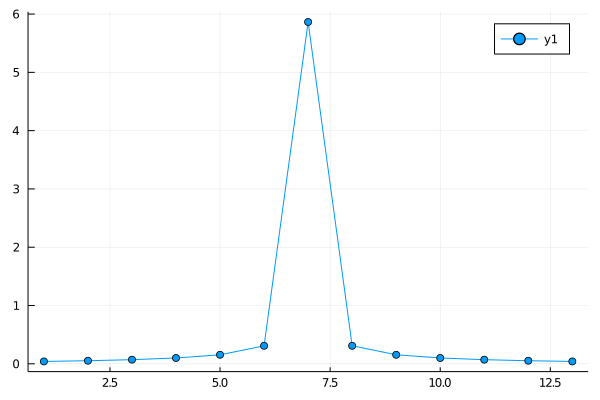

In [65]:
χupup = real.((χsp_in .+ χch_in)[usable_ω,:]);
plot(χupup[:,26], markershape=:circle)

In [1]:
1/600

0.0016666666666666668